In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

In [2]:
FHQ = pd.read_csv("data/FHQ.csv")
FHQ.name = "Family History Dataframe"
PAR = pd.read_csv("data/FAMXHPAR.csv")
PAR.name = "Parent Dataframe"
SIB = pd.read_csv("data/FAMXHSIB.csv")
SIB.name = "Sibling Dataframe"
DEM = pd.read_csv("data/PTDEMOG.csv")
DEM.name = "Demographics Dataframe"
ADN = pd.read_csv("data/ADNIMERGE.csv", low_memory=False)
ADN.name = "ADNI-merge Dataframe"
TEL = pd.read_csv("data/TS_RATIO_ADJ.csv")
TEL.name = "Telomere Dataframe"

# Additional Datasets

In the search for additional important predictors, we looked at some other datasets available on the ADNI database; namely, 

In [3]:
def unique_RIDs(DBS):
    m = f"Number of unique RIDs in {DBS.name}: "
    print(m,len(DBS['RID'].unique()))
for DBS in [FHQ,PAR,SIB,DEM,ADN,TEL]:
    unique_RIDs(DBS)


Number of unique RIDs in Family History Dataframe:  2677
Number of unique RIDs in Parent Dataframe:  592
Number of unique RIDs in Sibling Dataframe:  544
Number of unique RIDs in Demographics Dataframe:  3588
Number of unique RIDs in ADNI-merge Dataframe:  2092
Number of unique RIDs in Telomere Dataframe:  653


Demographics are already well represented in ADNI dataset; Parent and Sibling data set look too small to use, so we'll examine at family history and telomere datasets:

----
# Family History Dataset

In [26]:
famcols = ['FHQSOURCE','FHQPROV','FHQMOM','FHQMOMAD','FHQDAD','FHQDADAD','FHQSIB']
source = np.zeros(len(ADN))
prov = np.zeros(len(ADN))
mom = np.zeros(len(ADN))
momad = np.zeros(len(ADN))
dad = np.zeros(len(ADN))
dadad = np.zeros(len(ADN))
sib = np.zeros(len(ADN))

for i in range(len(ADN)):
    t = ADN.iloc[i].RID
    try:
        vals = FHQ[FHQ.RID==t].iloc[0][famcols].values
        source[i] = vals[0]
        prov[i] = vals[1]
        mom[i] = vals[2]
        momad[i] = vals[3]
        dad[i] = vals[4]
        dadad[i] = vals[5]
        sib[i] = vals[6]
    except IndexError:
        source[i] = np.nan
        prov[i] = np.nan
        mom[i] = np.nan
        momad[i] = np.nan
        dad[i] = np.nan
        dadad[i] = np.nan
        sib[i] = np.nan

In [29]:
Fam_df = pd.DataFrame()
Fam_df['FHQSOURCE'] = source
Fam_df['FHQPROV'] = prov
Fam_df['FHQMOM'] = mom
Fam_df['FHQMOMAD'] = momad
Fam_df['FHQDAD'] = dad
Fam_df['FHQDADAD'] = dadad
Fam_df['FHQSIB'] = sib
Fam_df['DX_bl'] = ADN['DX_bl'].map({'CN': 1, 'AD': 0, 'LMCI': 0, 'SMC': 0, 'EMCI': 0, 'NONE': 0})
Fam_df = Fam_df.replace(-4,np.nan)

In [31]:
# how many entries are not found not shared by fam and adni datasets
for i in famcols:
    print(i,": ",sum([math.isnan(s) for s in Fam_df[i]]))

FHQSOURCE :  6608
FHQPROV :  379
FHQMOM :  383
FHQMOMAD :  5444
FHQDAD :  379
FHQDADAD :  7150
FHQSIB :  379


In [32]:
Fam_df = Fam_df.dropna(axis=0)

In [33]:
Fam_df.describe()


,FHQSOURCE,FHQPROV,FHQMOM,FHQMOMAD,FHQDAD,FHQDADAD,FHQSIB,DX_bl
count,4958.00000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,1.00363,2.173054,0.354377,0.221259,0.148649,0.081484,0.894111,0.376563
std,0.06015,0.942306,0.478372,0.429937,0.355778,0.277267,0.307727,0.484573
min,1.00000,1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.00000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.00000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2.00000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
X = Fam_df.drop(['DX_bl'], axis=1)
y = Fam_df['DX_bl']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(ratio=1, random_state=42)
X_smote, y_smote = sm.fit_resample(X_train,y_train)

In [36]:
model = RandomForestClassifier(n_estimators=10, max_depth=10).fit(X_smote, y_smote)
model.score(X_test, y_test)

0.6875

In [37]:
np.mean(np.zeros(len(y_test))==y_test)

0.6320564516129032

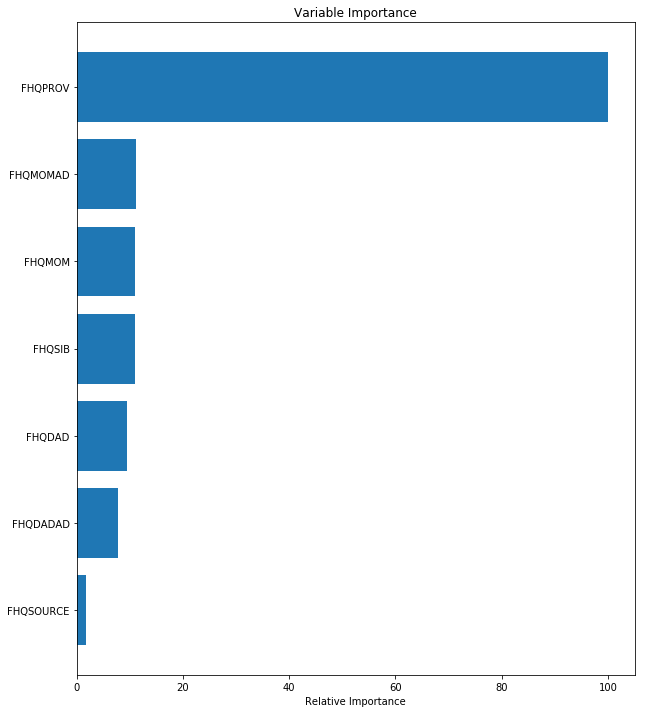

In [38]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

----
# Telomere Dataset

In [23]:
telcol = 'TL_BP_ADJ'
tel = np.zeros(len(ADN))
for i in range(len(ADN)):
    t = ADN.iloc[i].RID
    try:
        val = TEL[TEL.RID==t].iloc[0][telcol]
        tel[i] = val
    except IndexError:
        tel[i] = np.nan

In [28]:
Tel_df = pd.DataFrame()
Tel_df[telcol] = tel
Tel_df['DX_bl'] = ADN['DX_bl'].map({'CN': 1, 'AD': 0, 'LMCI': 0, 'SMC': 0, 'EMCI': 0, 'NONE': 0})


In [29]:
Tel_df = Tel_df.dropna(axis=0)
Tel_df.describe()


,TL_BP_ADJ,DX_bl
count,6749.000000,6749.000000
mean,5376.414762,0.365684
std,411.454311,0.481657
min,4559.080000,0.000000
25%,5098.580000,0.000000
50%,5316.370000,0.000000
75%,5632.150000,1.000000
max,7100.150000,1.000000


How is the below test score achieved???

In [30]:
X = Tel_df.drop(['DX_bl'], axis=1)
y = Tel_df['DX_bl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sm = SMOTE(ratio=1, random_state=42)
X_smote, y_smote = sm.fit_resample(X_train,y_train)
model = RandomForestClassifier(n_estimators=20, max_depth=20).fit(X_smote, y_smote)
pred = model.predict(X_test.values)
accuracy_score(pred,y_test.values)

0.9962962962962963

In [22]:
model2 = LogisticRegressionCV(cv=5, max_iter=10000).fit(X_smote,y_smote)
pred = model2.predict(X_test)
accuracy_score(pred,y_test.values)

0.6451851851851852

In [15]:
from sklearn.neighbors import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=5).fit(X_smote,y_smote)
model3.score(X_test.values,y_test.values)

0.9962962962962963

In [153]:
np.mean(np.zeros(len(y_test))==y_test)

0.6311111111111111

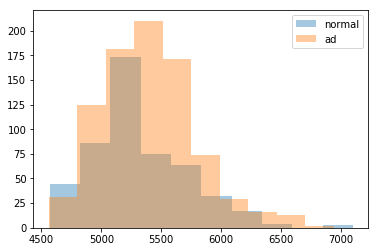

In [23]:
neg = X_test[y_test==1]
pos = X_test[y_test==0]
plt.hist(neg.values, alpha = 0.4, label = 'normal')
plt.hist(pos.values, alpha = 0.4, label = 'ad')
plt.legend()
plt.show()


In [16]:
X_test.values

array([[5029.64],
       [5221.65],
       [5714.6 ],
       ...,
       [4962.17],
       [4884.64],
       [5679.65]])

In [18]:
y_test

12475    0.0
11137    1.0
7511     1.0
5937     1.0
6338     0.0
4864     0.0
6178     0.0
7097     1.0
13300    1.0
12289    0.0
10466    1.0
9338     0.0
8118     0.0
11773    1.0
1134     1.0
8506     0.0
5435     1.0
4824     0.0
9777     0.0
4574     0.0
12572    1.0
9930     1.0
12321    1.0
6923     0.0
12008    0.0
13626    0.0
7837     1.0
11364    1.0
9045     1.0
12387    1.0
5398     0.0
11901    1.0
4647     0.0
10906    0.0
9395     0.0
7112     0.0
2108     1.0
10417    0.0
5085     0.0
9407     0.0
5634     0.0
3959     0.0
9432     0.0
7064     1.0
11173    1.0
4269     0.0
4835     0.0
1674     0.0
8305     0.0
12830    1.0
11715    1.0
4805     0.0
6566     1.0
496      1.0
11734    1.0
8081     0.0
10398    1.0
8432     1.0
10841    0.0
4315     0.0
11989    0.0
8759     0.0
12623    1.0
853      1.0
3550     0.0
11957    1.0
4448     1.0
12832    1.0
1228     0.0
8643     1.0
9489     0.0
9552     0.0
12382    1.0
9949     0.0
10844    0.0
4470     0.0
7620     0.0